# Využití statistického modelování
Vyhodnotíme chování systému návazných činností (teorie grafů) pomocí statistického modelování. Prostředkem bude událostní simulace.


In [0]:
import matplotlib.pyplot as plt
import networkx as nx
plt.rcParams["figure.figsize"] = (15,10)

# Teorie sítí
## Krátké připomenutí
Vrcholy, hrany. Hrana je vždy mezi dvěma vrcholy. Vrchol má obecně více hran.
Pro metodu CPM (Critical Path Method) je nezbytné mít orientovaný graf, tedy každá hrana má určený směr. Hrany jsou ohodnoceny trváním. 

Hrany tak představují činnosti, vrcholy pak definují návaznost činností.

Jestliže má trvání činnosti náhodný charakter, lze využít metodu PERT.

V úlohách lze aplikovat statistické modelování, při kterém jsou doby trvání náhodně generovány, graf je analyzován metodou CPM, výsledky analýzy jsou ukládány a nakonec vyhodnoceny.

## Příprava grafu

Není třeba studovat detailně

In [0]:
from random import random, gauss
from math import log as ln

G = nx.Graph()
G.add_node(0)

G = nx.DiGraph()
G.add_node('A')
G.add_node('B')
G.add_node('C')
G.add_node('D')
G.add_node('E')
G.add_node('F')
G.add_node('G')
G.add_node('H')
c = 0.01
pos = {
    'A': (c * 0, c * 50),
    'B': (c * 50, c * 25),
    'C': (c * 50, c * 75),
    'E': (c * 150, c * 25),
    'D': (c * 100, c * 50),
    'F': (c * 100, c * 100),
    'G': (c * 150, c * 75),
    'H': (c * 200, c * 50)
       }
G.add_edge('A', 'B', sigma = 1, mean = 30, current = 30)
G.add_edge('A', 'C', sigma = 3, mean = 20, current = 20)
G.add_edge('B', 'E', sigma = 2, mean = 10, current = 10)
G.add_edge('B', 'D', sigma = 4, mean = 40, current = 40)
G.add_edge('C', 'D', sigma = 1, mean = 20, current = 20)
G.add_edge('C', 'F', sigma = 2, mean = 20, current = 20)
G.add_edge('D', 'H', sigma = 3, mean = 30, current = 30)
G.add_edge('D', 'G', sigma = 1, mean = 20, current = 20)
G.add_edge('E', 'H', sigma = 4, mean = 10, current = 10)
G.add_edge('F', 'G', sigma = 2, mean = 30, current = 30)
G.add_edge('G', 'H', sigma = 2, mean = 40, current = 40)


## Metoda pro vizualizaci grafu
Není potřeba studovat

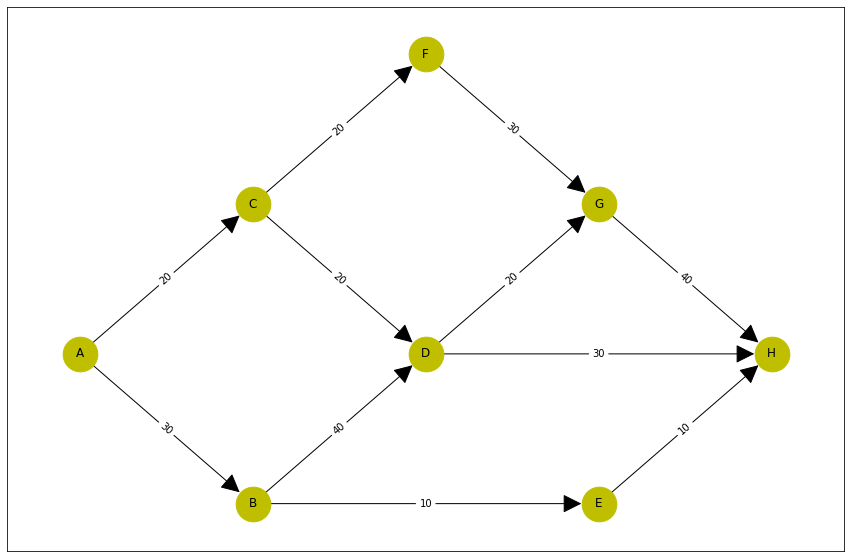

In [105]:
def printGraph(G):
  opts = { "with_labels": True, "node_color": 'y', 'arrowsize': 40, 'node_size': 1200 }
  #nx.draw_kamada_kawai(G, **opts)
  edge_labels = nx.get_edge_attributes(G, 'current')
  node_labels = nx.get_node_attributes(G, 'highRange')
  #print(node_labels)
  #_ = nx.networkx.draw_networkx_nodes(G, pos, **opts)
  _ = nx.networkx.draw_networkx_nodes(G, pos, **opts)
  _ = nx.networkx.draw_networkx_edges(G, pos, **opts)
  #_ = nx.networkx.draw_networkx_labels(G, pos, labels = node_labels, **opts)
  _ = nx.networkx.draw_networkx_labels(G, pos, **opts)
  _ = nx.networkx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, **opts)
  #_ = nx.networkx.draw_networkx_edge_labels(G, pos, **opts)

printGraph(G)

## Metody pro výpočet CPM
Není potřeba studovat

In [0]:

def initStatistic(G): # Inicializuje úložiště výsledků pro jednotlivé hrany
  for id, params in G.nodes.data():
    params['deltaHistory'] = []

def initNodesData(G): # Provádí inicializaci před výpočtem CPM
  for id, params in G.nodes.data():
    params['done'] = False #
    params['lowRange'] = 0
    params['highRange'] = 1000
    params['delta'] = 1000

def getAscendents(G, node): # Vrací následníky vrcholu v grafu
  for item in nx.networkx.classes.function.neighbors(G, node):
    yield item
  pass

def getPrecedents(G, node): # Vrací předchůdce vrcholu v grafu
  for startNode, endNode, attributes in G.edges.data():
    if endNode == node:
      yield startNode
  pass

def getNodeAttributes(G, node): # Vrací data uložená v grafu k příslušnému vrcholu
  for id, params in G.nodes.data():
    if id == node:
      return params
  return None

'''
def findUnsolvedNode(G):
  for node, attributes in G.nodes.data():
    if attributes['done'] == False:
      precedents = list(getPrecedents(G, node))#
      precedentsState = map(lambda item: getNodeAttribute(G, item)['done']) #
      if all(precedentsState): #
        return node #
'''
def forwardEvaluation(G, node): # První fáze CPM u daného uzlu
  timeMax = 0
  for id in getPrecedents(G, node):
    #print('forwardEvaluation', id)
    attributes = getNodeAttributes(G, id)
    edgeAttributes = G.get_edge_data(id, node)
    currentTime = attributes['lowRange'] + edgeAttributes['current']
    if timeMax < currentTime:
      timeMax = currentTime
  nodeAttributes = getNodeAttributes(G, node)
  nodeAttributes['lowRange'] = timeMax
  nodeAttributes['done'] = True

def forwardEvaluationAll(G, firstNode): # První fáze CPM u všech uzlů
  forwardEvaluation(G, firstNode)

  while True:
    goDeeper = False
    nodeToEvaluate = None
    for node, attributes in G.nodes.data():
      if attributes['done'] == False:
        done = False
        nodeToEvaluate = node
        break

    if nodeToEvaluate is None:
      break

    while True:
      goDeeper = False
      pre = list(getPrecedents(G, nodeToEvaluate))
      if len(pre) == 0:
        break
      for nextNode in pre:
        nextNodeAttributes = getNodeAttributes(G, nextNode)
        if nextNodeAttributes['done'] == False:
          nodeToEvaluate = nextNode
          goDeeper = True
          break
      if goDeeper == False:
        break

    forwardEvaluation(G, nodeToEvaluate)

def backwardEvaluation(G, node): # Druhá fáze CPM u daného uzlu
  timeMin = 1000
  for id in getAscendents(G, node):
    attributes = getNodeAttributes(G, id)
    edgeAttributes = G.get_edge_data(node, id)
    currentTime = attributes['highRange'] - edgeAttributes['current']
    #print(node, id, currentTime)
    if timeMin > currentTime:
      timeMin = currentTime
    #print(node, id, edgeAttributes)
  nodeAttributes = getNodeAttributes(G, node)
  nodeAttributes['highRange'] = timeMin
  nodeAttributes['done'] = True
  #print(nodeAttributes)
    
def backwardEvaluationAll(G, firstNode): # Druhá fáze CPM pro všechny uzly
  attributes = getNodeAttributes(G, firstNode)
  attributes['highRange'] = attributes['lowRange']
  attributes['done'] = True
  attributes = getNodeAttributes(G, firstNode)

  while True:
    done = True
    nodeToEvaluate = None
    for node, attributes in G.nodes.data():
      if attributes['done'] == False:
        done = False
        nodeToEvaluate = node
        break

    if nodeToEvaluate is None:
      break

    while True:
      goDeeper = False
      asc = list(getAscendents(G, nodeToEvaluate))
      if len(asc) == 0:
        break
      for nextNode in asc:
        nextNodeAttributes = getNodeAttributes(G, nextNode)
        if nextNodeAttributes['done'] == False:
          nodeToEvaluate = nextNode
          goDeeper = True
          break
      if goDeeper == False:
        break

    backwardEvaluation(G, nodeToEvaluate)

def cpm(G): # Kompletní metoda CPM
  initNodesData(G) # inicializace uzlů
  forwardEvaluationAll(G, 'A') # První fáze u všech uzlů
  for id, params in G.nodes.data(): # nastavení příznaku "Hotovo" pro druhou fázi
    params['done'] = False #
  backwardEvaluationAll(G, 'H') # Druhá fáze
  for id, params in G.nodes.data(): # Vyhodnocení rezerv pro všechny uzly
    params['delta'] = params['highRange'] - params['lowRange']

def collectStatistic(G): # Uložení výsledků pro pozdější statistické vyhodnocení
  for id, params in G.nodes.data():
    params['deltaHistory'].append(params['delta'])
  pass

def visualizeStatistic(G): # Vizualizace histogramů dob trvání u jednotlivých uzlů
  n_bins = 100
  for i, node in zip(range(0, 8), G.nodes()):
    fig, axs = plt.subplots(1, 1)
    x = getNodeAttributes(G, node)['deltaHistory']
    axs.hist(x, bins=n_bins)
    plt.title(node)
    plt.grid(which = 'both')
    plt.show()
    



## Simulace 
Pomocí opakovaných simulací náhodného grafu - délek trvání a následných výpočtů můžeme získat statistická data a ta následně vyhodnotit.
```python
def randomizeGraph(G)
```
je metodou, která přiřadí hranám náhodné trvání (Gaussovo rozdělení):
```python
params['current'] = gauss(params['mean'], params['sigma'])
```
Takto připravený graf je spočítán, výsledek je uložen a toto se opakuje několikrát. Na konci je k dispozici sada statistických dat, která lze vyhodnotit / zobrazit. 

Pozor na historgramy u vrcholů, které jsou na kritické cestě. Tady se projevuje přesnost výpočtu. Nulou se rozumí interval $(-1\cdot 10^{-10};1\cdot 10^{-10})$.

V kódu níže si změňte řádky
```python
    params['current'] = gauss(params['mean'], params['sigma']) 
    #params['current'] = 2 * params['sigma'] * random() + params['mean']
```
za řádky
```python
    #params['current'] = gauss(params['mean'], params['sigma']) 
    params['current'] = 2 * params['sigma'] * random() + params['mean']
```
Tím změníte náhodné veličiny pro generování dob trvání činností. Proveďte simulaci a porovnejte výsledky. 

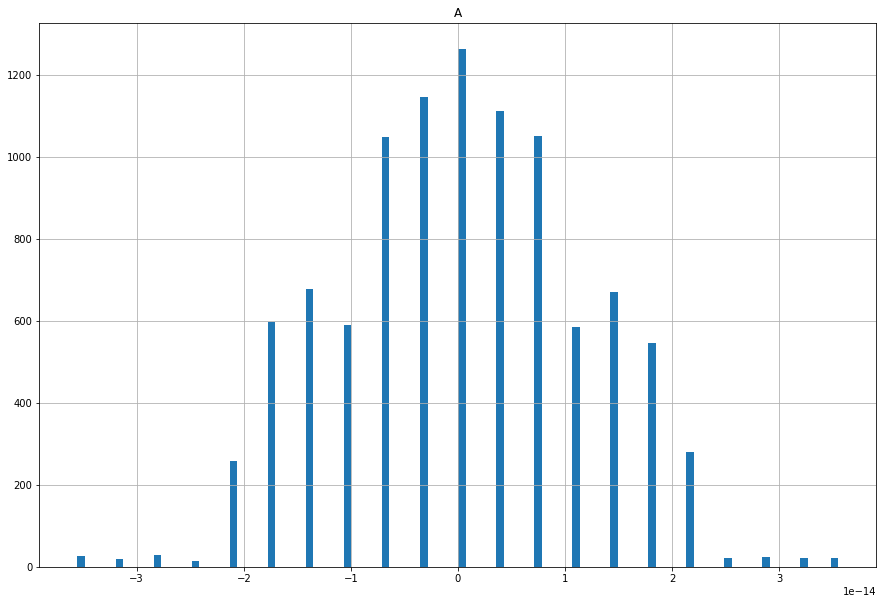

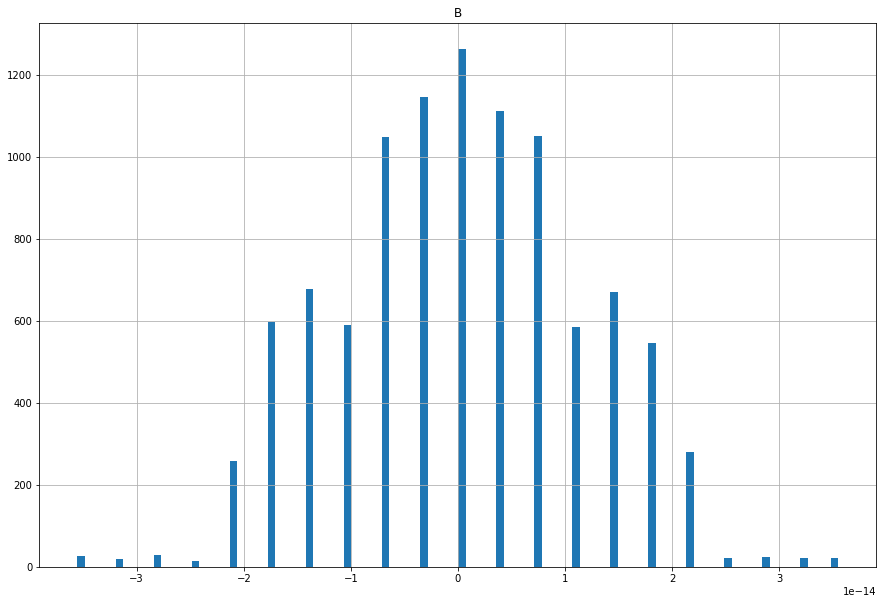

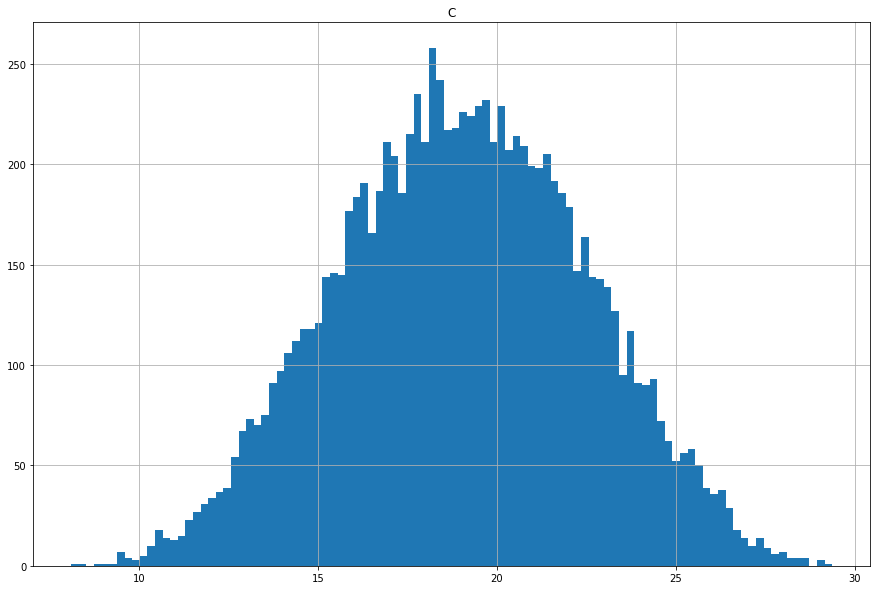

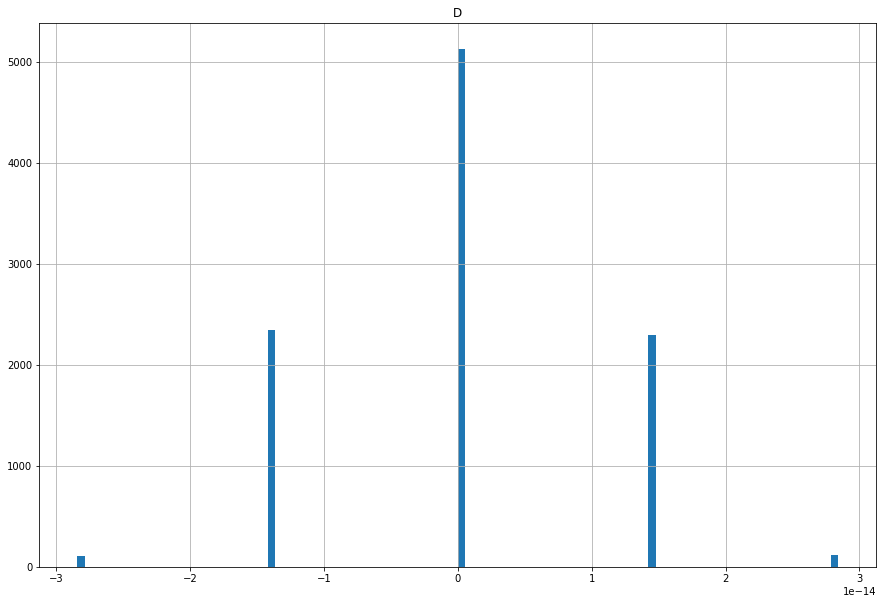

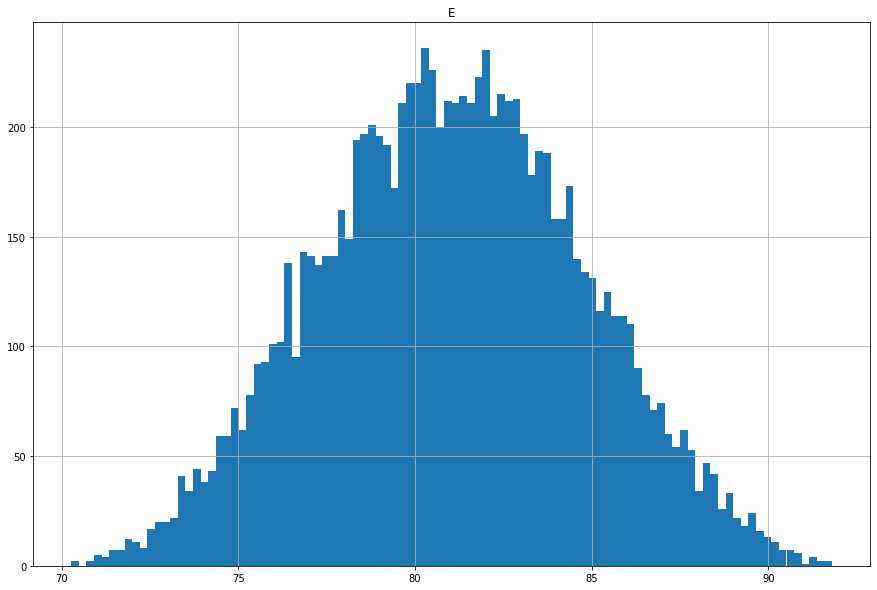

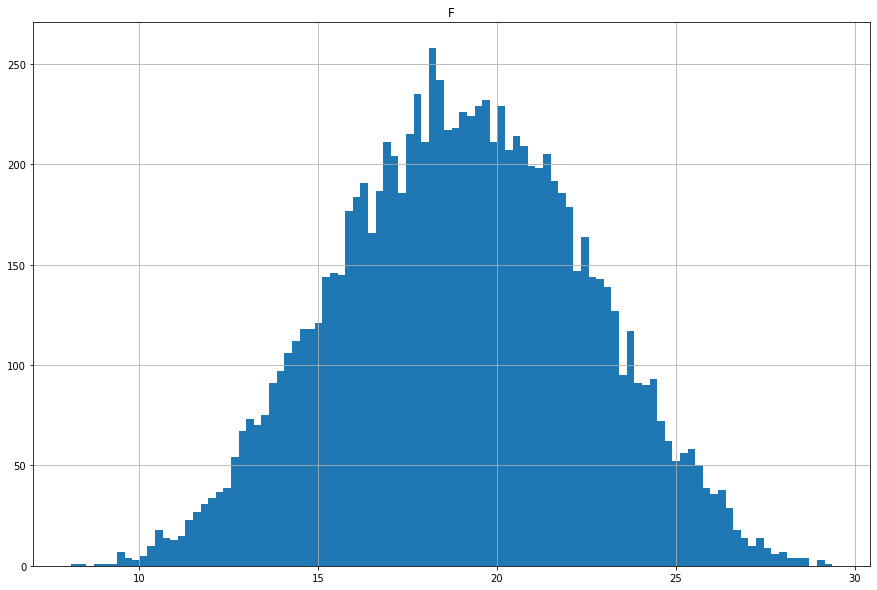

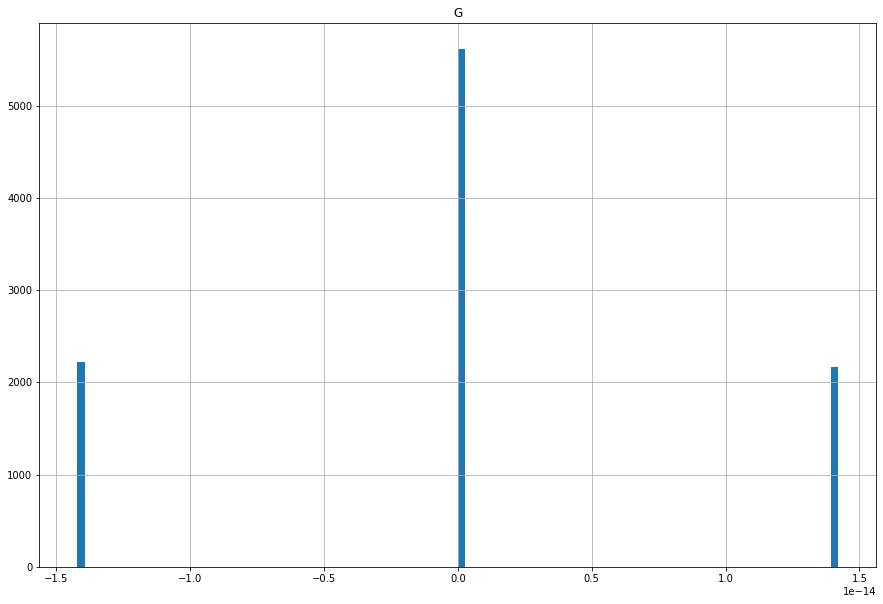

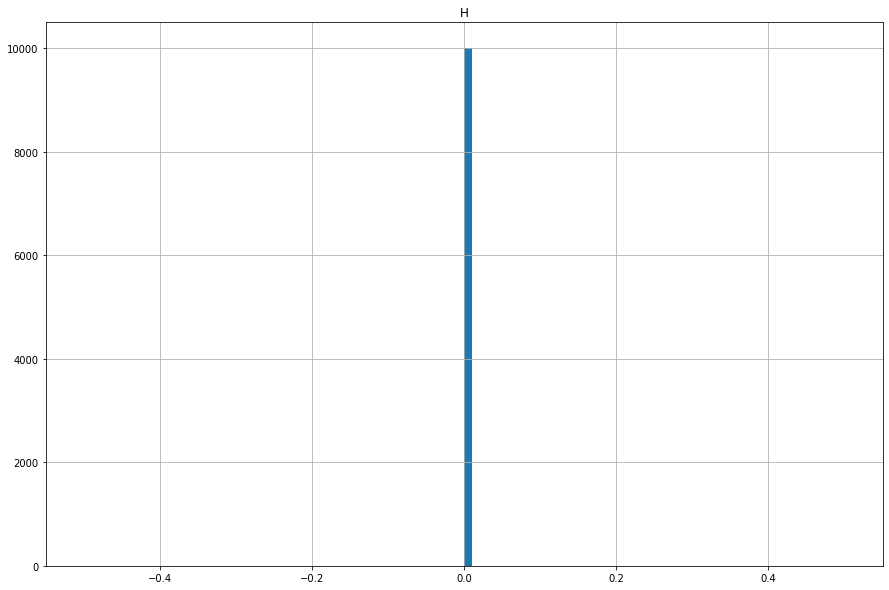

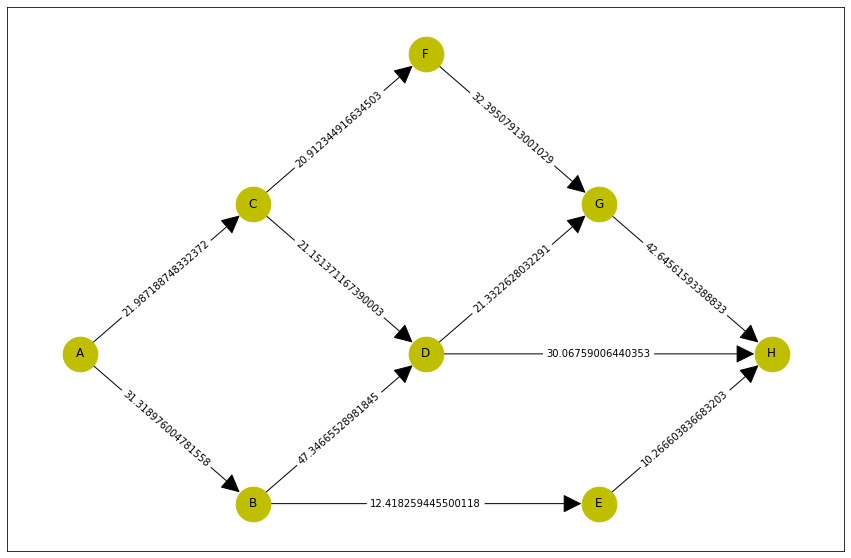

In [108]:
def randomizeGraph(G):
  for startNode, endNode, params in G.edges.data():
    params['current'] = gauss(params['mean'], params['sigma']) # náhodná doba trvání - rozložení Gaussovo
    #params['current'] = 2 * params['sigma'] * random() + params['mean'] # náhodná doba trvání - rovnoměrné rozdělení
    if params['current'] < 0: # trvání nesmí mít zápornou hodnotu
      params['current'] = 1
    

initStatistic(G) # vynulování statistik
for i in range(0, 10000): # opakovaný běh
  randomizeGraph(G) # přiřazení dob trvání
  cpm(G) # vyčíslení
  collectStatistic(G) # sběr statistik

visualizeStatistic(G) # zobrazení obrázků
printGraph(G) # vizualizace grafu


## Závěr
V tomto konkrétní příkladu grafu lze vidět, jaká jsou rozložení časových rezerv v případě jednotlivých vrcholů. Vrcholy A, B, D, G a H jsou na kritické cestě a tedy případné zpoždění na hranách A-B, B-D, D-G a G-H vedou ke zpoždění celého projektu. 

Statistické modelování s využitím výpočetní techniky umožňuje u jednotlivých činností - hran definovat zcela volně náhodná rozdělení a následně provést celkové zhodnocení. Analytickými metodami toto není možné.